In [14]:
%%capture
!pip install pandas nltk scipy matplotlib openpyxl

In [2]:
import pandas as pd
import re
import json

dataframe: pd.DataFrame = pd.read_csv(f"../resources/sampled_reviews_with_output_phi3_medium.csv")

In [3]:
dataframe.head(5)

,Unnamed: 0,review,sentiment,entities,json,progressive_index,output,index,level_0
0,434.0,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",NaN,NaN
1,3278.0,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",NaN,NaN
2,967.0,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",NaN,NaN
3,1982.0,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983.0,"```json\n{\n ""sentiment"": ""positive"",\n ""re...",NaN,NaN
4,2902.0,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",NaN,NaN


In [4]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smoothing_function: SmoothingFunction = SmoothingFunction()

ZERO_SCORE = ({
                  "review_score": .0,
                  "sentiment_score": .0,
                  "ner_score": {
                      "accuracy": .0,
                      "precision": .0,
                      "recall": .0,
                      "f1": .0
                  }
              }, .0)


def compute_bleu(reference: str, hypothesis: str) -> float:
    """
    It computes the BLEU score between hypothesis and reference.

    Arguments:
        hypothesis (list[str]): The hypothesis.
        reference (list[list[str]]): The reference.

    Return:
        The BLEU score.
    """
    return corpus_bleu([[reference.split()]], [hypothesis.split()], smoothing_function=smoothing_function.method1)


def evaluate(row: pd.DataFrame) -> (dict, float):
    try:
        ground_truth: dict = json.loads(row["json"])
    except Exception as e:
        print(str(e))
        return ZERO_SCORE, 0.0
    output: str = row["output"]
    groups = re.findall(pattern=r"(\{.*})", flags=re.DOTALL, string=output)
    if len(groups) != 1:
        return ZERO_SCORE

    group: str = groups[0]
    try:
        output_dict: dict = json.loads(group)
    except json.JSONDecodeError as e:
        print(str(e))
        return ZERO_SCORE

    review_score: float = compute_bleu(ground_truth["review"], output_dict["review"]) if "review" in output_dict else .0
    sentiment_score: float = 1.0 if "sentiment" in output_dict and output_dict["sentiment"] == ground_truth[
        "sentiment"] else 0.0

    ground_truth_entities: list[str] = ground_truth["entities"]
    score: dict = {
        "review_score": review_score,
        "sentiment_score": sentiment_score,
        "ner_score": {
            "accuracy": .0,
            "precision": .0,
            "recall": .0,
            "f1": .0
        }
    }
    if "entities" not in output_dict:
        return score, sum([review_score, sentiment_score, .0]) / 3.0

    detected_entities = output_dict["entities"] if "entities" in output_dict else []
    if len(detected_entities) == 0 and len(ground_truth_entities) == 0:
        score["ner_score"]["accuracy"] = 1.0
        score["ner_score"]["precision"] = 1.0
        score["ner_score"]["recall"] = 1.0
        score["ner_score"]["f1"] = 1.0
        return score, sum([review_score, sentiment_score, 1.0]) / 3.0

    false_negatives: int = 0  # Quelli che ci sono in GT, ma non nei detected
    false_positives: int = 0  # Quelli che sono stati individuati, ma non ci sono in GT
    true_positives: int = 0  # Quelli che sono stati correttamente individuati

    for ge in ground_truth_entities:
        ge_found: bool = False
        for de in detected_entities:
            if "label" not in de or "value" not in de or len(de.items()) != 2:
                continue
            label: str = de["label"]
            value: str = de["value"]
            if label == ge["label"] and value == ge["value"]:
                ge_found = True
                break
        if ge_found:
            true_positives += 1
        else:
            false_negatives += 1

    for de in detected_entities:
        if "label" not in de or "value" not in de or len(de.items()) != 2:
            false_positives += 1
            continue
        label: str = de["label"]
        value: str = de["value"]
        ge_found: bool = False
        for ge in ground_truth_entities:
            if label == ge["label"] and value == ge["value"]:
                ge_found = True
                break
        if not ge_found:
            false_positives += 1

    score["ner_score"]["accuracy"]: float = true_positives / (
            true_positives + false_positives) if true_positives + false_positives > 0 else .0
    score["ner_score"]["precision"]: float = true_positives / (
            true_positives + false_positives) if true_positives + false_positives > 0 else .0
    score["ner_score"]["recall"]: float = true_positives / (
                true_positives + false_negatives) if true_positives + false_negatives > 0 else .0
    score["ner_score"]["f1"] = 2 * (score["ner_score"]["precision"] * score["ner_score"]["recall"]) / (
                score["ner_score"]["precision"] + score["ner_score"]["recall"]) if (score["ner_score"]["precision"] +
                                                                                    score["ner_score"][
                                                                                        "recall"]) > 0 else .0

    return score, sum([review_score, sentiment_score, score["ner_score"]["f1"]]) / 3.0


In [5]:
dataframe["score"] = dataframe.apply(
    lambda row: evaluate(row)[1], axis=1)
dataframe["score_detail"] = dataframe.apply(
    lambda row: evaluate(row)[0], axis=1)
if "level_0" in dataframe.columns:
    dataframe.drop(columns=["level_0"], inplace=True)
if "index" in dataframe.columns:
    dataframe.drop(columns=["index"], inplace=True)
dataframe.reset_index(inplace=True)
dataframe

Invalid control character at: line 11 column 19 (char 365)
Invalid control character at: line 3 column 380 (char 408)
Invalid control character at: line 3 column 138 (char 166)
Expecting ':' delimiter: line 11 column 14 (char 332)
Expecting ',' delimiter: line 3 column 274 (char 302)
Invalid control character at: line 3 column 199 (char 227)
Invalid control character at: line 19 column 11 (char 374)
Invalid control character at: line 3 column 431 (char 459)
Expecting ',' delimiter: line 3 column 532 (char 560)
Invalid control character at: line 15 column 11 (char 1012)
Invalid control character at: line 3 column 452 (char 480)
Expecting ',' delimiter: line 7 column 19 (char 228)
Expecting ',' delimiter: line 3 column 806 (char 834)
Invalid control character at: line 14 column 13 (char 1596)
Expecting ',' delimiter: line 3 column 98 (char 126)
Invalid control character at: line 3 column 519 (char 547)
Expecting ',' delimiter: line 15 column 23 (char 1361)
Invalid control character at: l

,index,Unnamed: 0,review,sentiment,entities,json,progressive_index,output,score,score_detail
0,0,434.0,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.000000,"{'review_score': 0.0, 'sentiment_score': 0.0, ..."
1,1,3278.0,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.001166,"{'review_score': 0.0034988210954885095, 'senti..."
2,2,967.0,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.333610,"{'review_score': 0.000830176019450272, 'sentim..."
3,3,1982.0,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983.0,"```json\n{\n ""sentiment"": ""positive"",\n ""re...",0.000008,"{'review_score': 2.5074096666966153e-05, 'sent..."
4,4,2902.0,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.001260,"{'review_score': 0.0037800365417970617, 'senti..."
...,...,...,...,...,...,...,...,...,...,...
1594,1594,401.0,I mistakenly thought that this neo-noir effort...,negative,"[{'label': 'ORG', 'value': 'MTV'}, {'label': '...","{""review"": ""I mistakenly thought that this neo...",402.0,$$$,0.000000,"{'review_score': 0.0, 'sentiment_score': 0.0, ..."
1595,1595,1747.0,This film is awful. Not offensive but extremel...,negative,"[{'label': 'PERSON', 'value': 'Winona Ryder'},...","{""review"": ""This film is awful. Not offensive ...",1748.0,$$$,0.000000,"{'review_score': 0.0, 'sentiment_score': 0.0, ..."
1596,1596,4406.0,"""Cut"" is a full-tilt spoof of the slasher genr...",positive,"[{'label': 'PERSON', 'value': 'Kylie Minogue'}...","{""review"": ""\""Cut\"" is a full-tilt spoof of th...",4407.0,$$$,0.000000,"{'review_score': 0.0, 'sentiment_score': 0.0, ..."
1597,1597,2738.0,I agree with most of the other guys. A waste o...,negative,"[{'label': 'PERSON', 'value': 'Olli Dittrich'}...","{""review"": ""I agree with most of the other guy...",2739.0,$$$,0.000000,"{'review_score': 0.0, 'sentiment_score': 0.0, ..."


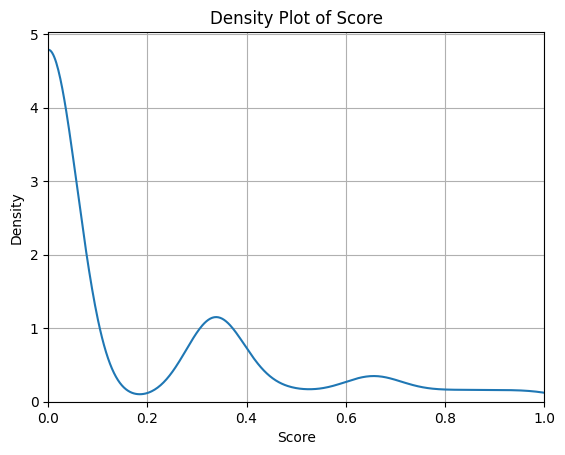

In [12]:
import matplotlib.pyplot as plt

ax = dataframe["score"].plot(kind="kde")

# Set the x-axis limit to start from 0
ax.set_xlim(left=0.0, right=1.0)
ax.set_ylim(bottom=0.0)

# Add labels and title
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Density Plot of Score')
plt.grid(True)

# Show the plot
plt.show()

In [15]:
dataframe.to_excel("../resources/sampled_reviews_with_output_phi3_medium.xlsx")